In [1]:
import mdtraj as md
import glob as glob
from scipy import spatial
from collections import defaultdict
from tqdm import tqdm_notebook
import numpy as np
import os

In [2]:
def clusterer(files, threshold=0.5, interchain=True, intraresidue=False, return_type=0, debug=True):
    
    """
    Function to calculate the number of contacts each residue has with neighbouring residues
    
    v0.1: First version, only has one parameter, the threshold setting
    v0.2: Vectorised distance calculation with pyml calculate_distance 
          (~100 times speed increase in distance calculation)
    v0.3: Fully vectorised distance calculation with scipy (~100x speed increase overall)
    v0.4: Added inter/intra chain option, inter/intra residue and return value type 
          (residue label or position or both)
    v0.5: added documentation
    
    :type directory: list
    :type threshold: float
    :type interchain: bool
    :type intraresidue: bool
    :type return_type: int
    :type debug: bool
    
    :param directory: files to run calculation
    :param threshold: threshold in nm in contact definition
    :param interchain: whether to look at interchain contacts
    :param intraresidue: whether to look for interactions within the same residue
    :param return_type: 0 returns label and position, 1 returns only residue label and 2 returns only position
    :param debug: switch on debug mode
    
    :rtype: dict
    :return: a dict with dictionaries with the contacts for each each residue  
    
    Pseudocode:
    -----------
        1. for each file in directory:
            a. Read PDB to extract residue names
            b. Parse file with mdtraj
            c. initialise contacts dict
            d. Calculate dense matrix with euclidean distances and then convert to squareform
            f. for each position below threshold:
                i. Find out position of corresponding atom
               ii. store appropriate data
        2. Return dictionary (with key corresponding to file) with contacts of each file
    """
    
    # stores data
    result = dict()
    
    # iterate over each file
    for file in tqdm_notebook(files):
        
        file_name = os.path.split(file)[-1].split('.')[0] # get file basename
        
        # maps each atom to a residue
        atom_map = dict()
        
        # parse file (PDB)
        with open(file, 'r') as f:
            file_length = 0
            i=0
            for line in f.readlines():
    
                line_el = line.split()
                  
                # if line has less than 6 elements it doesn't contain relevant information
                if len(line_el) < 6:
                    continue
                
                # try to extract info from line and raise error with line string if it fails
                try:
                    # only get info from sidechain atoms
                    
                    if line_el[2] not in ['N', 'O', 'CA', 'C']:
                        # store chain, residue number and residue name
                        atom_map[i] = (line_el[4], line_el[5], line_el[3])
                        i+=1
                except:
                    raise ValueError(line)
        
        # store model result in a dict
        result_i = dict()
        
        # load pdb with mdtraj
        model = md.load_pdb(file)
        
        # remove backbone
        model = model.atom_slice(model.top.select('all and sidechain'))
        
        # number of sidechain atoms
        atoms = model.n_atoms
        
        # contacts are stored in a set, since we are only looking for
        # any contact with another amino acid,
        # e.g. it doesn't matter if atom 1 is in contact with two 
        # alanines, so we would have in this case:
        # contact[atom1] = {ALA}
        contacts = defaultdict(set)
        
        # calculate the distance between all side chain atoms using scipy's pdist function
        # model.xyz.squeeze(0) reshapes the 3D matrix (with time dimension) to a 2D matrix
        # the squareform function converts the flat array to a square matrix, which
        # takes up more memory but it easier to work with
        dists = spatial.distance.squareform(spatial.distance.pdist(model.xyz.squeeze(0)))

        # get indices where the distance between atoms is below threshold
        # this provides a list:
        #  - atom1 position in sequence
        #  - atom2 position in sequence
        dist_threshold = np.where(dists < threshold)
        
        # iterate over each pair of atoms forming a contact
        for atom1, atom2 in zip(dist_threshold[0], dist_threshold[1]):
            
            # store chain and residue number
            # e.g. position1 = 'L1' -> first residue of light chain
            position1 = atom_map[atom1][0]+atom_map[atom1][1]
            position2 = atom_map[atom2][0]+atom_map[atom2][1]
            
            if not interchain and position1[0] != position2[0]:
                # if atoms are in different chains skip
                continue
                
            if not intraresidue and position1 == position2:
                # skip if atoms are in same residue
                continue
            
            if return_type == 0:
                # store information about chain+residue number and amino acid 
                contacts[position1].add((position2, atom_map[atom2][2]))
            elif return_type == 1:
                # store information about amino acid
                contacts[position1].add(atom_map[atom2][2])
            elif return_type == 2:
                # store information about chain+residue number
                contacts[position1].add(position2)
            else:
                raise ValueError("Unknown return type!")
        
        # for each file store result
        result[file_name] = contacts
                
    return result

In [3]:
files = glob.glob('../models/*pdb')
result = clusterer(files, 0.5, debug=False)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [4]:
aa_order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [5]:
three_letter ={'V':'VAL', 'I':'ILE', 'L':'LEU', 'E':'GLU', 'Q':'GLN',
'D':'ASP', 'N':'ASN', 'H':'HIS', 'W':'TRP', 'F':'PHE', 'Y':'TYR',
'R':'ARG', 'K':'LYS', 'S':'SER', 'T':'THR', 'M':'MET', 'A':'ALA',
'G':'GLY', 'P':'PRO', 'C':'CYS'}

In [6]:
import json

# load numbering data  and put it in a list (NOTE that this only works with python >= 3.5)
with open('/home/gil/AbPyTools/abpytools/data/NumberingSchemes.json') as f:
    data = json.load(f)['chothia']
    heavy_data = data['heavy']
    light_data = data['light']
    
    numbering_data = [*heavy_data, *light_data]

In [7]:
def vector_representation(data):
    """
    Function to represent cluster data in vector form
    
    :type data: dict
    
    :param data: data from clusterer
    
    :rtype: dict
    :return: returns dict with same keys as data containing a dict 
             with the vector for each position
             
    Explanation:
    ------------
    
    Each vector has the following order:
    
    [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
    
    Each position either takes up the value of 0 (no contact) or 1 (contact)
    
    """
    
    result = dict()
    
    for key, value in tqdm_notebook(data.items()):
        
        file_result = dict()
        
        for pos in numbering_data:
            
            if pos in value:
                res_list = [x[1] for x in value[pos]] 
                file_result[pos] = [1 if three_letter[x] in res_list else 0 for x in aa_order]
            else:
                file_result[pos] = [0] * 20
            
        result[key] = file_result
                
    return result

In [8]:
vectors = vector_representation(result)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [9]:
h1_vectors = []
h1_labels = []
for file, data in vectors.items():
    if 'H1' in data:
        if sum(data['H1']) > 0:
            h1_vectors.append(data['H1'])
            h1_labels.append(file)

In [10]:
len(vectors)

900

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [12]:
len(h1_vectors)

294

In [13]:
clustered_data = linkage(y=spatial.distance.pdist(h1_vectors, metric='cosine'))

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

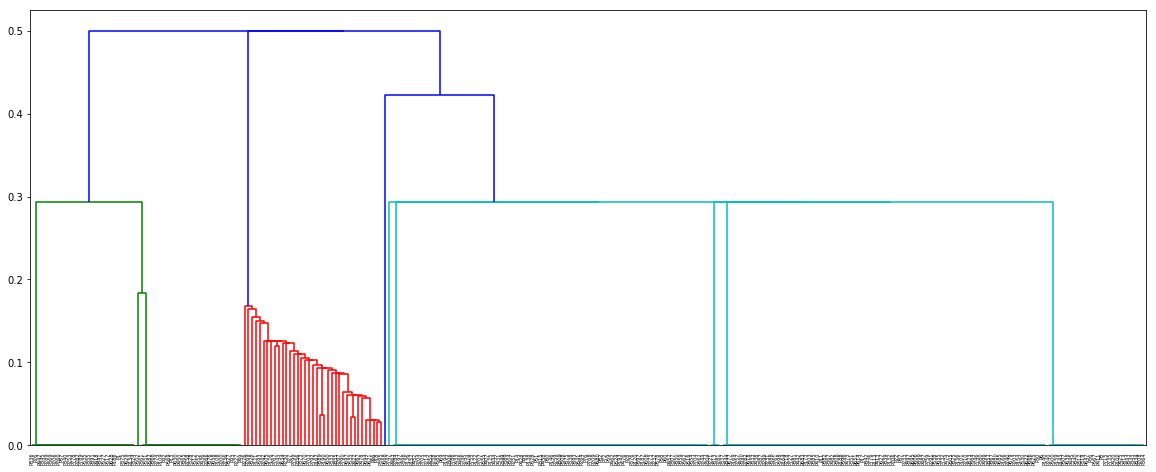

In [15]:
f, ax = plt.subplots(1, 1, figsize=(20,8))
dendrogram(clustered_data, labels=h1_labels)
plt.show()

In [16]:
from natsort import natsorted

In [17]:
matrix= [np.array([vectors[model][x] for x in natsorted(vectors[model].keys())]).flatten() for model in natsorted(vectors.keys())]

In [18]:
matrix = np.concatenate((matrix)).reshape(900,-1)

In [19]:
from sklearn.decomposition import PCA, TruncatedSVD

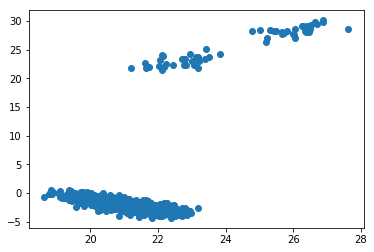

In [20]:
svd = TruncatedSVD(n_components=100)
reduced = svd.fit_transform(matrix)
plt.scatter(reduced[:,0], reduced[:,1])

In [21]:
import pandas as pd

In [22]:
data = pd.read_csv('/home/gil/PhD/Data/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

In [23]:
data = data.join(pd.DataFrame(reduced, index=['P' + str(x) for x in range(900)]))

In [24]:
data.head()

,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
P2,64.473820,0.000000,NaN,NaN,26.389905,29.131334,-2.200656,-1.902497,-3.447406,0.563947,...,0.690119,1.056552,-3.315164,4.601439,-1.458576,-0.893639,3.410525,1.143557,12.324826,-4.612751
P3,73.982970,0.130358,NaN,NaN,20.482271,-0.668682,6.402926,7.973608,3.840277,1.445204,...,0.133638,0.086078,0.114774,0.057465,0.014830,-0.069428,0.134285,-0.107073,0.026251,-0.278107
P4,64.326010,0.060344,NaN,NaN,21.016079,-2.053480,-4.642119,-1.436880,-4.775858,6.910315,...,-0.014231,0.041109,0.213867,0.065171,-0.035963,0.029109,0.061236,0.134402,0.095608,0.091755
P6,74.192370,0.036953,NaN,NaN,21.910243,-3.172687,-4.967663,-0.936541,-5.619913,1.603518,...,-0.036740,0.054534,-0.022663,0.041094,-0.128433,0.082741,-0.122074,-0.001099,0.137863,0.150944
P9,72.899025,0.085337,NaN,NaN,22.321633,-3.211787,-4.391595,-1.154308,-5.572494,-3.638526,...,-0.067883,0.219268,-0.075588,-0.003801,-0.073124,0.107386,0.082556,0.017751,0.065194,0.007438


In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")

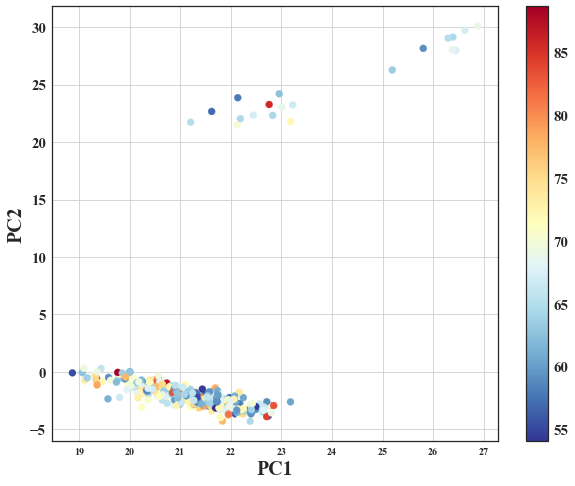

In [26]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(1, 1, figsize=(10, 8))

    plt.scatter(data[0], data[1], c=data['Tm D - Mean'], cmap='RdYlBu_r', s=50)
    plt.colorbar()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.grid()

In [27]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [28]:
data = data[~np.isnan(data['Tm D - Mean'])]
X_train, X_test, y_train, y_test = train_test_split(data.ix[:,4:].values, data['Tm D - Mean'].values, 
                                                    test_size=0.3, random_state=1970)

/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [29]:
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1]))

model.compile(optimizer='rmsprop', loss='mean_squared_error',metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 101       
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [30]:
# callbacks = EarlyStopping(min_delta=1, patience=10)
callbacks = ModelCheckpoint('./bestClusterModel.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=[callbacks])

Train on 212 samples, validate on 92 samples
Epoch 1/1000
212/212 [==============================] - 0s - loss: 5283.1038 - mean_squared_error: 5283.1038 - val_loss: 5191.8917 - val_mean_squared_error: 5191.8917
Epoch 2/1000
212/212 [==============================] - 0s - loss: 5243.0544 - mean_squared_error: 5243.0544 - val_loss: 5166.3532 - val_mean_squared_error: 5166.3532
Epoch 3/1000
212/212 [==============================] - 0s - loss: 5213.7135 - mean_squared_error: 5213.7135 - val_loss: 5143.3521 - val_mean_squared_error: 5143.3521
Epoch 4/1000
212/212 [==============================] - 0s - loss: 5187.0827 - mean_squared_error: 5187.0827 - val_loss: 5121.4450 - val_mean_squared_error: 5121.4450
Epoch 5/1000
212/212 [==============================] - 0s - loss: 5161.2880 - mean_squared_error: 5161.2880 - val_loss: 5099.7575 - val_mean_squared_error: 5099.7575
Epoch 6/1000
212/212 [==============================] - 0s - loss: 5135.9918 - mean_squared_error: 5135.9918 - val_loss:

212/212 [==============================] - 0s - loss: 4120.6742 - mean_squared_error: 4120.6742 - val_loss: 4217.0503 - val_mean_squared_error: 4217.0503
Epoch 50/1000
212/212 [==============================] - 0s - loss: 4098.7040 - mean_squared_error: 4098.7040 - val_loss: 4197.8698 - val_mean_squared_error: 4197.8698
Epoch 51/1000
212/212 [==============================] - 0s - loss: 4076.6020 - mean_squared_error: 4076.6020 - val_loss: 4178.9385 - val_mean_squared_error: 4178.9385
Epoch 52/1000
212/212 [==============================] - 0s - loss: 4054.5383 - mean_squared_error: 4054.5383 - val_loss: 4159.7999 - val_mean_squared_error: 4159.7999
Epoch 53/1000
212/212 [==============================] - 0s - loss: 4032.5862 - mean_squared_error: 4032.5862 - val_loss: 4141.0512 - val_mean_squared_error: 4141.0512
Epoch 54/1000
212/212 [==============================] - 0s - loss: 4010.5261 - mean_squared_error: 4010.5261 - val_loss: 4122.0840 - val_mean_squared_error: 4122.0840
Epoch 

212/212 [==============================] - 0s - loss: 3129.0027 - mean_squared_error: 3129.0027 - val_loss: 3354.6958 - val_mean_squared_error: 3354.6958
Epoch 98/1000
212/212 [==============================] - 0s - loss: 3109.8193 - mean_squared_error: 3109.8193 - val_loss: 3337.9088 - val_mean_squared_error: 3337.9088
Epoch 99/1000
212/212 [==============================] - 0s - loss: 3090.8894 - mean_squared_error: 3090.8894 - val_loss: 3321.1913 - val_mean_squared_error: 3321.1913
Epoch 100/1000
212/212 [==============================] - 0s - loss: 3071.8537 - mean_squared_error: 3071.8537 - val_loss: 3304.4869 - val_mean_squared_error: 3304.4869
Epoch 101/1000
212/212 [==============================] - 0s - loss: 3053.0089 - mean_squared_error: 3053.0089 - val_loss: 3287.8087 - val_mean_squared_error: 3287.8087
Epoch 102/1000
212/212 [==============================] - 0s - loss: 3034.2615 - mean_squared_error: 3034.2615 - val_loss: 3271.3499 - val_mean_squared_error: 3271.3499
Epo

212/212 [==============================] - 0s - loss: 2284.0706 - mean_squared_error: 2284.0706 - val_loss: 2599.1011 - val_mean_squared_error: 2599.1011
Epoch 146/1000
212/212 [==============================] - 0s - loss: 2268.0430 - mean_squared_error: 2268.0430 - val_loss: 2584.4174 - val_mean_squared_error: 2584.4174
Epoch 147/1000
212/212 [==============================] - 0s - loss: 2252.1493 - mean_squared_error: 2252.1493 - val_loss: 2569.5768 - val_mean_squared_error: 2569.5768
Epoch 148/1000
212/212 [==============================] - 0s - loss: 2236.2043 - mean_squared_error: 2236.2043 - val_loss: 2554.8560 - val_mean_squared_error: 2554.8560
Epoch 149/1000
212/212 [==============================] - 0s - loss: 2220.4921 - mean_squared_error: 2220.4921 - val_loss: 2540.1261 - val_mean_squared_error: 2540.1261
Epoch 150/1000
212/212 [==============================] - 0s - loss: 2204.6749 - mean_squared_error: 2204.6749 - val_loss: 2525.7966 - val_mean_squared_error: 2525.7966
E

212/212 [==============================] - 0s - loss: 1583.4144 - mean_squared_error: 1583.4144 - val_loss: 1944.8008 - val_mean_squared_error: 1944.8008
Epoch 194/1000
212/212 [==============================] - 0s - loss: 1570.3039 - mean_squared_error: 1570.3039 - val_loss: 1932.3292 - val_mean_squared_error: 1932.3292
Epoch 195/1000
212/212 [==============================] - 0s - loss: 1557.2532 - mean_squared_error: 1557.2532 - val_loss: 1919.9292 - val_mean_squared_error: 1919.9292
Epoch 196/1000
212/212 [==============================] - 0s - loss: 1544.2272 - mean_squared_error: 1544.2272 - val_loss: 1907.4750 - val_mean_squared_error: 1907.4750
Epoch 197/1000
212/212 [==============================] - 0s - loss: 1531.2993 - mean_squared_error: 1531.2993 - val_loss: 1895.1251 - val_mean_squared_error: 1895.1251
Epoch 198/1000
212/212 [==============================] - 0s - loss: 1518.4996 - mean_squared_error: 1518.4996 - val_loss: 1882.6698 - val_mean_squared_error: 1882.6698
E

212/212 [==============================] - 0s - loss: 1022.5530 - mean_squared_error: 1022.5530 - val_loss: 1394.0663 - val_mean_squared_error: 1394.0663
Epoch 242/1000
212/212 [==============================] - 0s - loss: 1012.4048 - mean_squared_error: 1012.4048 - val_loss: 1383.6209 - val_mean_squared_error: 1383.6209
Epoch 243/1000
212/212 [==============================] - 0s - loss: 1002.2721 - mean_squared_error: 1002.2721 - val_loss: 1373.1972 - val_mean_squared_error: 1373.1972
Epoch 244/1000
212/212 [==============================] - 0s - loss: 992.0766 - mean_squared_error: 992.0766 - val_loss: 1363.0217 - val_mean_squared_error: 1363.0217
Epoch 245/1000
212/212 [==============================] - 0s - loss: 982.0363 - mean_squared_error: 982.0363 - val_loss: 1352.6795 - val_mean_squared_error: 1352.6795
Epoch 246/1000
212/212 [==============================] - 0s - loss: 972.0307 - mean_squared_error: 972.0307 - val_loss: 1342.3838 - val_mean_squared_error: 1342.3838
Epoch 2

212/212 [==============================] - 0s - loss: 589.4924 - mean_squared_error: 589.4924 - val_loss: 936.9780 - val_mean_squared_error: 936.9780
Epoch 291/1000
212/212 [==============================] - 0s - loss: 582.1452 - mean_squared_error: 582.1452 - val_loss: 928.5832 - val_mean_squared_error: 928.5832
Epoch 292/1000
212/212 [==============================] - 0s - loss: 574.7799 - mean_squared_error: 574.7799 - val_loss: 920.2403 - val_mean_squared_error: 920.2403
Epoch 293/1000
212/212 [==============================] - 0s - loss: 567.4837 - mean_squared_error: 567.4837 - val_loss: 912.0639 - val_mean_squared_error: 912.0639
Epoch 294/1000
212/212 [==============================] - 0s - loss: 560.2409 - mean_squared_error: 560.2409 - val_loss: 904.1001 - val_mean_squared_error: 904.1001
Epoch 295/1000
212/212 [==============================] - 0s - loss: 553.0927 - mean_squared_error: 553.0927 - val_loss: 896.1164 - val_mean_squared_error: 896.1164
Epoch 296/1000
212/212 [=

212/212 [==============================] - 0s - loss: 291.0920 - mean_squared_error: 291.0920 - val_loss: 582.7766 - val_mean_squared_error: 582.7766
Epoch 340/1000
212/212 [==============================] - 0s - loss: 286.4024 - mean_squared_error: 286.4024 - val_loss: 576.6175 - val_mean_squared_error: 576.6175
Epoch 341/1000
212/212 [==============================] - 0s - loss: 281.5788 - mean_squared_error: 281.5788 - val_loss: 570.3608 - val_mean_squared_error: 570.3608
Epoch 342/1000
212/212 [==============================] - 0s - loss: 276.8370 - mean_squared_error: 276.8370 - val_loss: 564.2157 - val_mean_squared_error: 564.2157
Epoch 343/1000
212/212 [==============================] - 0s - loss: 272.2076 - mean_squared_error: 272.2076 - val_loss: 558.2402 - val_mean_squared_error: 558.2402
Epoch 344/1000
212/212 [==============================] - 0s - loss: 267.6664 - mean_squared_error: 267.6664 - val_loss: 552.3797 - val_mean_squared_error: 552.3797
Epoch 345/1000
212/212 [=

212/212 [==============================] - 0s - loss: 116.9770 - mean_squared_error: 116.9770 - val_loss: 329.5363 - val_mean_squared_error: 329.5363
Epoch 389/1000
212/212 [==============================] - 0s - loss: 114.6503 - mean_squared_error: 114.6503 - val_loss: 325.3874 - val_mean_squared_error: 325.3874
Epoch 390/1000
212/212 [==============================] - 0s - loss: 112.3230 - mean_squared_error: 112.3230 - val_loss: 321.4551 - val_mean_squared_error: 321.4551
Epoch 391/1000
212/212 [==============================] - 0s - loss: 110.0979 - mean_squared_error: 110.0979 - val_loss: 317.4464 - val_mean_squared_error: 317.4464
Epoch 392/1000
212/212 [==============================] - 0s - loss: 107.8800 - mean_squared_error: 107.8800 - val_loss: 313.4297 - val_mean_squared_error: 313.4297
Epoch 393/1000
212/212 [==============================] - 0s - loss: 105.6637 - mean_squared_error: 105.6637 - val_loss: 309.4774 - val_mean_squared_error: 309.4774
Epoch 394/1000
212/212 [=

212/212 [==============================] - 0s - loss: 51.5614 - mean_squared_error: 51.5614 - val_loss: 184.1299 - val_mean_squared_error: 184.1299
Epoch 439/1000
212/212 [==============================] - 0s - loss: 51.1670 - mean_squared_error: 51.1670 - val_loss: 182.8321 - val_mean_squared_error: 182.8321
Epoch 440/1000
212/212 [==============================] - 0s - loss: 50.8296 - mean_squared_error: 50.8296 - val_loss: 181.5949 - val_mean_squared_error: 181.5949
Epoch 441/1000
212/212 [==============================] - 0s - loss: 50.4924 - mean_squared_error: 50.4924 - val_loss: 180.2586 - val_mean_squared_error: 180.2586
Epoch 442/1000
212/212 [==============================] - 0s - loss: 50.1224 - mean_squared_error: 50.1224 - val_loss: 178.9803 - val_mean_squared_error: 178.9803
Epoch 443/1000
212/212 [==============================] - 0s - loss: 49.8103 - mean_squared_error: 49.8103 - val_loss: 177.8153 - val_mean_squared_error: 177.8153
Epoch 444/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 41.3054 - mean_squared_error: 41.3054 - val_loss: 149.1677 - val_mean_squared_error: 149.1677
Epoch 489/1000
212/212 [==============================] - 0s - loss: 41.1745 - mean_squared_error: 41.1745 - val_loss: 148.7803 - val_mean_squared_error: 148.7803
Epoch 490/1000
212/212 [==============================] - 0s - loss: 41.0607 - mean_squared_error: 41.0607 - val_loss: 148.2322 - val_mean_squared_error: 148.2322
Epoch 491/1000
212/212 [==============================] - 0s - loss: 40.9602 - mean_squared_error: 40.9602 - val_loss: 147.9335 - val_mean_squared_error: 147.9335
Epoch 492/1000
212/212 [==============================] - 0s - loss: 40.8142 - mean_squared_error: 40.8142 - val_loss: 147.4390 - val_mean_squared_error: 147.4390
Epoch 493/1000
212/212 [==============================] - 0s - loss: 40.7346 - mean_squared_error: 40.7346 - val_loss: 147.0408 - val_mean_squared_error: 147.0408
Epoch 494/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 37.0180 - mean_squared_error: 37.0180 - val_loss: 135.0801 - val_mean_squared_error: 135.0801
Epoch 539/1000
212/212 [==============================] - 0s - loss: 36.9553 - mean_squared_error: 36.9553 - val_loss: 134.7768 - val_mean_squared_error: 134.7768
Epoch 540/1000
212/212 [==============================] - 0s - loss: 36.9272 - mean_squared_error: 36.9272 - val_loss: 134.6807 - val_mean_squared_error: 134.6807
Epoch 541/1000
212/212 [==============================] - 0s - loss: 36.8544 - mean_squared_error: 36.8544 - val_loss: 134.5352 - val_mean_squared_error: 134.5352
Epoch 542/1000
212/212 [==============================] - 0s - loss: 36.7964 - mean_squared_error: 36.7964 - val_loss: 134.4405 - val_mean_squared_error: 134.4405
Epoch 543/1000
212/212 [==============================] - 0s - loss: 36.7616 - mean_squared_error: 36.7616 - val_loss: 134.2440 - val_mean_squared_error: 134.2440
Epoch 544/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 34.7975 - mean_squared_error: 34.7975 - val_loss: 128.4529 - val_mean_squared_error: 128.4529
Epoch 589/1000
212/212 [==============================] - 0s - loss: 34.7990 - mean_squared_error: 34.7990 - val_loss: 128.4704 - val_mean_squared_error: 128.4704
Epoch 590/1000
212/212 [==============================] - 0s - loss: 34.7293 - mean_squared_error: 34.7293 - val_loss: 128.3492 - val_mean_squared_error: 128.3492
Epoch 591/1000
212/212 [==============================] - 0s - loss: 34.7196 - mean_squared_error: 34.7196 - val_loss: 128.2459 - val_mean_squared_error: 128.2459
Epoch 592/1000
212/212 [==============================] - 0s - loss: 34.6821 - mean_squared_error: 34.6821 - val_loss: 128.1924 - val_mean_squared_error: 128.1924
Epoch 593/1000
212/212 [==============================] - 0s - loss: 34.6209 - mean_squared_error: 34.6209 - val_loss: 128.1632 - val_mean_squared_error: 128.1632
Epoch 594/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 33.5185 - mean_squared_error: 33.5185 - val_loss: 125.5084 - val_mean_squared_error: 125.5084
Epoch 639/1000
212/212 [==============================] - 0s - loss: 33.4807 - mean_squared_error: 33.4807 - val_loss: 125.4779 - val_mean_squared_error: 125.4779
Epoch 640/1000
212/212 [==============================] - 0s - loss: 33.4718 - mean_squared_error: 33.4718 - val_loss: 125.4295 - val_mean_squared_error: 125.4295
Epoch 641/1000
212/212 [==============================] - 0s - loss: 33.4547 - mean_squared_error: 33.4547 - val_loss: 125.4752 - val_mean_squared_error: 125.4752
Epoch 642/1000
212/212 [==============================] - 0s - loss: 33.4389 - mean_squared_error: 33.4389 - val_loss: 125.4650 - val_mean_squared_error: 125.4650
Epoch 643/1000
212/212 [==============================] - 0s - loss: 33.4164 - mean_squared_error: 33.4164 - val_loss: 125.4631 - val_mean_squared_error: 125.4631
Epoch 644/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 32.6518 - mean_squared_error: 32.6518 - val_loss: 124.7385 - val_mean_squared_error: 124.7385
Epoch 689/1000
212/212 [==============================] - 0s - loss: 32.6287 - mean_squared_error: 32.6287 - val_loss: 124.7764 - val_mean_squared_error: 124.7764
Epoch 690/1000
212/212 [==============================] - 0s - loss: 32.6224 - mean_squared_error: 32.6224 - val_loss: 124.8451 - val_mean_squared_error: 124.8451
Epoch 691/1000
212/212 [==============================] - 0s - loss: 32.6128 - mean_squared_error: 32.6128 - val_loss: 124.8629 - val_mean_squared_error: 124.8629
Epoch 692/1000
212/212 [==============================] - 0s - loss: 32.6252 - mean_squared_error: 32.6252 - val_loss: 124.9117 - val_mean_squared_error: 124.9117
Epoch 693/1000
212/212 [==============================] - 0s - loss: 32.5989 - mean_squared_error: 32.5989 - val_loss: 124.8938 - val_mean_squared_error: 124.8938
Epoch 694/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 32.0448 - mean_squared_error: 32.0448 - val_loss: 125.7982 - val_mean_squared_error: 125.7982
Epoch 739/1000
212/212 [==============================] - 0s - loss: 32.0348 - mean_squared_error: 32.0348 - val_loss: 125.8539 - val_mean_squared_error: 125.8539
Epoch 740/1000
212/212 [==============================] - 0s - loss: 32.0285 - mean_squared_error: 32.0285 - val_loss: 125.9195 - val_mean_squared_error: 125.9195
Epoch 741/1000
212/212 [==============================] - 0s - loss: 32.0133 - mean_squared_error: 32.0133 - val_loss: 125.8973 - val_mean_squared_error: 125.8973
Epoch 742/1000
212/212 [==============================] - 0s - loss: 32.0116 - mean_squared_error: 32.0116 - val_loss: 125.9252 - val_mean_squared_error: 125.9252
Epoch 743/1000
212/212 [==============================] - 0s - loss: 31.9964 - mean_squared_error: 31.9964 - val_loss: 125.9481 - val_mean_squared_error: 125.9481
Epoch 744/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 31.5882 - mean_squared_error: 31.5882 - val_loss: 127.3768 - val_mean_squared_error: 127.3768
Epoch 789/1000
212/212 [==============================] - 0s - loss: 31.5672 - mean_squared_error: 31.5672 - val_loss: 127.3804 - val_mean_squared_error: 127.3804
Epoch 790/1000
212/212 [==============================] - 0s - loss: 31.5477 - mean_squared_error: 31.5477 - val_loss: 127.4233 - val_mean_squared_error: 127.4233
Epoch 791/1000
212/212 [==============================] - 0s - loss: 31.5707 - mean_squared_error: 31.5707 - val_loss: 127.4815 - val_mean_squared_error: 127.4815
Epoch 792/1000
212/212 [==============================] - 0s - loss: 31.5516 - mean_squared_error: 31.5516 - val_loss: 127.5335 - val_mean_squared_error: 127.5335
Epoch 793/1000
212/212 [==============================] - 0s - loss: 31.5560 - mean_squared_error: 31.5560 - val_loss: 127.5342 - val_mean_squared_error: 127.5342
Epoch 794/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 31.1819 - mean_squared_error: 31.1819 - val_loss: 129.8220 - val_mean_squared_error: 129.8220
Epoch 839/1000
212/212 [==============================] - 0s - loss: 31.2129 - mean_squared_error: 31.2129 - val_loss: 129.8551 - val_mean_squared_error: 129.8551
Epoch 840/1000
212/212 [==============================] - 0s - loss: 31.1986 - mean_squared_error: 31.1986 - val_loss: 129.9293 - val_mean_squared_error: 129.9293
Epoch 841/1000
212/212 [==============================] - 0s - loss: 31.1643 - mean_squared_error: 31.1643 - val_loss: 129.9691 - val_mean_squared_error: 129.9691
Epoch 842/1000
212/212 [==============================] - 0s - loss: 31.1708 - mean_squared_error: 31.1708 - val_loss: 130.0892 - val_mean_squared_error: 130.0892
Epoch 843/1000
212/212 [==============================] - 0s - loss: 31.1824 - mean_squared_error: 31.1824 - val_loss: 130.0952 - val_mean_squared_error: 130.0952
Epoch 844/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 30.8808 - mean_squared_error: 30.8808 - val_loss: 132.6275 - val_mean_squared_error: 132.6275
Epoch 889/1000
212/212 [==============================] - 0s - loss: 30.8862 - mean_squared_error: 30.8862 - val_loss: 132.6848 - val_mean_squared_error: 132.6848
Epoch 890/1000
212/212 [==============================] - 0s - loss: 30.8582 - mean_squared_error: 30.8582 - val_loss: 132.7609 - val_mean_squared_error: 132.7609
Epoch 891/1000
212/212 [==============================] - 0s - loss: 30.8810 - mean_squared_error: 30.8810 - val_loss: 132.8623 - val_mean_squared_error: 132.8623
Epoch 892/1000
212/212 [==============================] - 0s - loss: 30.8540 - mean_squared_error: 30.8540 - val_loss: 132.9179 - val_mean_squared_error: 132.9179
Epoch 893/1000
212/212 [==============================] - 0s - loss: 30.8619 - mean_squared_error: 30.8619 - val_loss: 133.0069 - val_mean_squared_error: 133.0069
Epoch 894/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 30.6282 - mean_squared_error: 30.6282 - val_loss: 135.9725 - val_mean_squared_error: 135.9725
Epoch 939/1000
212/212 [==============================] - 0s - loss: 30.6327 - mean_squared_error: 30.6327 - val_loss: 136.0783 - val_mean_squared_error: 136.0783
Epoch 940/1000
212/212 [==============================] - 0s - loss: 30.5945 - mean_squared_error: 30.5945 - val_loss: 136.1359 - val_mean_squared_error: 136.1359
Epoch 941/1000
212/212 [==============================] - 0s - loss: 30.5879 - mean_squared_error: 30.5879 - val_loss: 136.2658 - val_mean_squared_error: 136.2658
Epoch 942/1000
212/212 [==============================] - 0s - loss: 30.6036 - mean_squared_error: 30.6036 - val_loss: 136.3218 - val_mean_squared_error: 136.3218
Epoch 943/1000
212/212 [==============================] - 0s - loss: 30.5832 - mean_squared_error: 30.5832 - val_loss: 136.3830 - val_mean_squared_error: 136.3830
Epoch 944/1000
212/212 [=============

212/212 [==============================] - 0s - loss: 30.3661 - mean_squared_error: 30.3661 - val_loss: 140.1697 - val_mean_squared_error: 140.1697
Epoch 989/1000
212/212 [==============================] - 0s - loss: 30.3660 - mean_squared_error: 30.3660 - val_loss: 140.2004 - val_mean_squared_error: 140.2004
Epoch 990/1000
212/212 [==============================] - 0s - loss: 30.3617 - mean_squared_error: 30.3617 - val_loss: 140.2709 - val_mean_squared_error: 140.2709
Epoch 991/1000
212/212 [==============================] - 0s - loss: 30.3741 - mean_squared_error: 30.3741 - val_loss: 140.4077 - val_mean_squared_error: 140.4077
Epoch 992/1000
212/212 [==============================] - 0s - loss: 30.3371 - mean_squared_error: 30.3371 - val_loss: 140.5236 - val_mean_squared_error: 140.5236
Epoch 993/1000
212/212 [==============================] - 0s - loss: 30.3479 - mean_squared_error: 30.3479 - val_loss: 140.6278 - val_mean_squared_error: 140.6278
Epoch 994/1000
212/212 [=============

In [31]:
model.load_weights('./bestClusterModel.h5')

In [32]:
from sklearn.metrics import r2_score

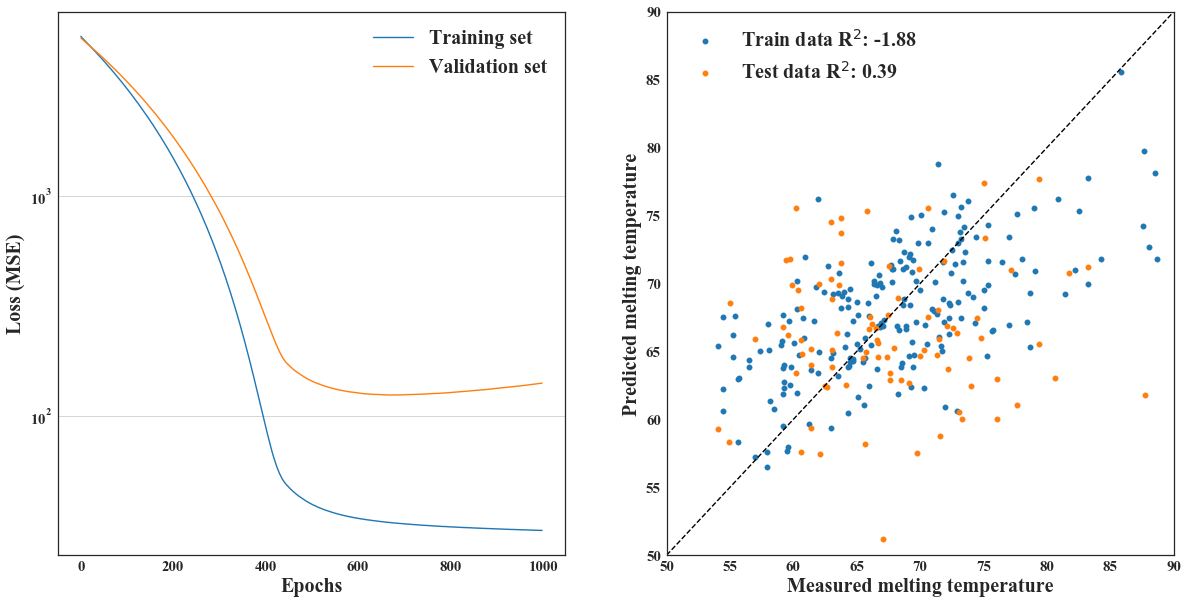

In [33]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 15,
                              'ytick.labelsize': 15, 'legend.fontsize': 20}):
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].semilogy(history.history['loss'], label='Training set')
    ax[0].semilogy(history.history['val_loss'], label='Validation set')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].grid(axis='y')
    
    ax[1].scatter(y_train, model.predict(X_train), label='Train data R$^2$: {:.2f}'.
                  format(r2_score(y_test, model.predict(X_test))))
    ax[1].scatter(y_test, model.predict(X_test), label='Test data R$^2$: {:.2f}'.
                 format(r2_score(y_train, model.predict(X_train))))
    
    ax[1].plot([50, 90], [50, 90], linestyle='--',c='k')
    
    ax[1].set_ylim(50, 90)
    ax[1].set_xlim(50, 90)

#     ax[1].text(56, 81.2,
#                'Test set R$^2$: {:.2f}'.
#                format(r2_score(y_test, model.predict(X_test))),
#                {'size': 20})
#     ax[1].text(56, 83.2,
#                'Training set R$^2$: {:.2f}'.
#                format(r2_score(y_train, model.predict(X_train))),
#                {'size': 20})
    
    ax[1].legend()
    
    ax[1].set_ylabel('Predicted melting temperature')
    ax[1].set_xlabel('Measured melting temperature')